# Multinomial Logistic Regression
First prediction method to be tested will be the multinomial logistic regression model. It will serve as a comparative baseline for more advanced models such as Random Forest or neural networks like Convolutional Neural Network. It is a multinomial logistic regression, because it is a classifier with multiple class options.


In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
def getData():
    data = pd.read_csv('data/fashion-mnist_train.csv')
    X = data.drop('label', axis=1)
    y = data['label']
    return X, y

In [ ]:
def runLogisticRegression(X, y):
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    model = LogisticRegression(max_iter=10000)
    results = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    return results

In [11]:
X, y = getData()

### Dimensionality reduction using PCA
Because the training data consists of 60000 sample images where each image is made up of 784 pixels (28x28 pixels), running a simple Multinomial Logistic Regression with 5-fold CV is time consuming to calculate. In order to attempt to reduce the processing time, I will investigate whether the dataset can be reduced through reducing the number of features using PCA.

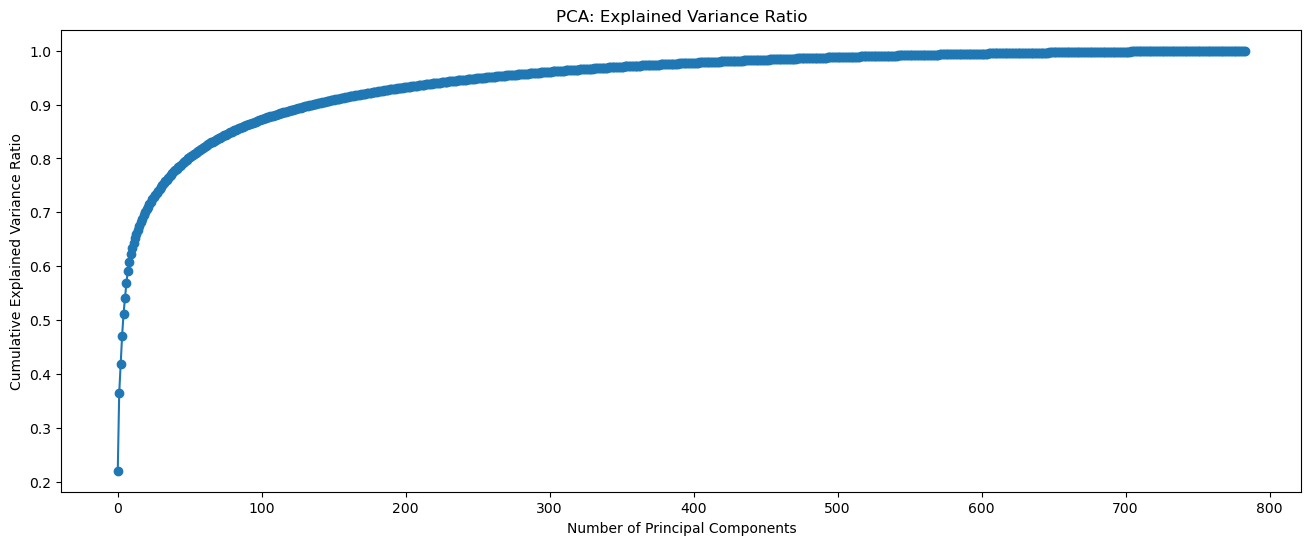

In [ ]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA()
X_reduced = pca.fit_transform(X_scaled)

# Get explained variance
explained_variance = pca.explained_variance_
total_variance = explained_variance.sum()

# Plot the explained variance ratio
plt.figure(figsize=(16, 6))
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA: Explained Variance Ratio')
plt.show()

From the plot it is clear that the far majority of the fatures are not necessary. By simply reducing the number of features to 200, it can still retain close to 90% of the variance. I will experiement with features in the range from 50 to 200, possibly landing somewhere closer to 200 features total, which is still an overall data reduction from near 800 original features.

In [40]:
# Experiment with different numbers of PCA components

for i in range(1, 5):
    num_components = i * 50
    X_reduced = PCA(n_components=num_components).fit_transform(X_scaled)
    results = runLogisticRegression(X_reduced, y)
    print(f'Accuracy with {num_components} PCA components:')
    print(f'Accuracy for each fold: {results}')
    print(f'Average accuracy: {results.mean():.2f}')


Accuracy with 50 PCA components:
Accuracy for each fold: [0.8325     0.83466667 0.83691667 0.83083333 0.83283333]
Average accuracy: 0.83
Accuracy with 100 PCA components:
Accuracy for each fold: [0.84666667 0.84491667 0.85041667 0.84375    0.84825   ]
Average accuracy: 0.85
Accuracy with 150 PCA components:
Accuracy for each fold: [0.85291667 0.85208333 0.85341667 0.84958333 0.85308333]
Average accuracy: 0.85
Accuracy with 200 PCA components:
Accuracy for each fold: [0.854      0.85216667 0.85558333 0.85091667 0.85575   ]
Average accuracy: 0.85


Finally, I had to increase the number of maximum iterations for Logistic Regression, since it struggled to converge for larger amounts of features relative to the features in the dataset. That means that even for the lowest amount of features I would test (50 features) would result in the model not reaching convergence with a max iteration set to 1000. Therefore, I decided to increase the limitation to 2000, which allowed it model to converge. 

Also note that from the above accuracy results for a range of different number of PCA components, the accuracy does not become much better after 50 components when seen relative to the amount of extra components used for each new training round. Therefore, I will only use 50 components for the final performance evaluation on the test set.

### LR - Model Accuracy on Test Data
In the following code, it will run the Logistic Regression model (using only 50 features) on the separate test data set. This will show how well the model works for unseen data, and will also reveal whether the model might have overfitted to the training dataset.

In [7]:
# Test data:
test_data = pd.read_csv('data/fashion-mnist_test.csv')
X_test = test_data.drop('label', axis=1)
y_test = test_data['label']

In [9]:
# Chosen model:
model = LogisticRegression(max_iter=10000)
X_reduced = PCA(n_components=50).fit_transform(X_scaled)
model.fit(X_reduced, y)

# Predict on test data
X_test_scaled = scaler.transform(X_test)
X_test_reduced = PCA(n_components=50).fit_transform(X_test_scaled)
y_pred = model.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred)
print(f'Logistic Regression Model Accuracy on test data: {accuracy}, and in percentage: {accuracy * 100:.2f}%')

Logistic Regression Model Accuracy on test data: 0.3699, and in percentage: 36.99%


## Model Evalution
From the above results, it would be fair to assume that the model has become too complex from overfitting to the training data. To try and mitigate it, I could add regularization to the model. It could also be due to an excessive amount of features, even after the decrease from nearly 800 features to just 50 features. So, it could be an idea to run a new round of training and testing with even fewer features (at the cost of accuracy on the training data), and possibly also introduce a regularization term (e.g. L1 or L2).

# Random Forest
The idea of the Random Forest algorithm is to utilize multiple smaller decision trees which are each slightly different from one another. The reason for each of them being slightly different is due to a decision tree not using all features, instead it randomly selects a few of the features, which makes it quite useful for very large datasets.
Note, that because of this random construction of the decision trees, every prediction will give some unique insights based on what features the given tree chose to focus on. And based on the previous analysis of the data using Logistic Regression and PCA, not all the features are important, so it will be interesting to see the prediction accuracy with this specific approach.

In [10]:
# Imports for Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [12]:
def trainModel(X, y, model):
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

    results = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    return results

## Random Forest with full dataset
First I will run a Random Forest Classifier on the whole dataset, initially without any hyperparameter tuning, and then comparatively with hyperparameter tuning using RandomSearchCV.

In [ ]:
# Train Random Forest Model with no hyperparameter tuning

rf_model = RandomForestClassifier()
res = trainModel(X, y, rf_model)
print(f'Random Forest Accuracy with all features:')
print(f'Accuracy for each fold: {res}')
print(f'Average accuracy: {res.mean():.2f}')

Random Forest Accuracy with all features:
Accuracy for each fold: [0.878      0.87925    0.88716667 0.87975    0.882     ]
Average accuracy: 0.88


In [14]:
# Test model on test data
rf_model.fit(X, y)
y_rf_pred = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_rf_pred)

print(f'Random Forest Model Accuracy on test data: {accuracy_rf}, and in percentage: {accuracy_rf * 100:.2f}%')

Random Forest Model Accuracy on test data: 0.8848, and in percentage: 88.48%


This is a very good score compared to the Logistic Regression Model, and it is also clear that contrary to the previous model, this one is not overfitted to the training data, and is therefore able to adapt quite well to new unseen data. However, this is the results from the simple standard Random Forest Model, so I will use sklearn's RandomizedSearchCV to see whether some hyperparameters can be tuned to make the models performance even better.

In [24]:
# Train Random Forest Model with hyperparameter tuning
# Define the parameter grid for RandomizedSearchCV

def tuneHyperParams(X, y, params):
    rf_model = RandomForestClassifier()
    best_rf = RandomizedSearchCV( rf_model, 
                                        param_distributions=params, 
                                        n_iter=5, 
                                        cv=5, 
                                        scoring='accuracy', 
                                        random_state=42,
                                        n_jobs=-1) # Added to parallelize the search across CPU cores.
    best_rf.fit(X, y)
    return best_rf

In [26]:
param_dist = {
    'n_estimators': [150, 200, 250],
    'max_depth': [20, 30, 40]
}


tuned_rf_result = tuneHyperParams(X, y, param_dist)
print(f'Best hyperparameters: {tuned_rf_result.best_params_}')

Best hyperparameters: {'n_estimators': 250, 'max_depth': 40}


In [27]:
# Get the scoring results from the RandomizedSearchCV
cv_results = tuned_rf_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
print(f'Mean test scores for each hyperparameter combination: {mean_test_scores}')
print(f'Hyperparameter combinations tested: {cv_results["params"]}')

Mean test scores for each hyperparameter combination: [0.88238333 0.88115    0.88336667 0.88123333 0.88351667]
Hyperparameter combinations tested: [{'n_estimators': 200, 'max_depth': 40}, {'n_estimators': 200, 'max_depth': 20}, {'n_estimators': 250, 'max_depth': 30}, {'n_estimators': 150, 'max_depth': 20}, {'n_estimators': 250, 'max_depth': 40}]


In [28]:
# Test the best Random Forest model on the test data using the RandomizedSearchCV best estimator
y_best_rf_pred = tuned_rf_result.best_estimator_.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_best_rf_pred)
print(f'Best Random Forest Model Accuracy on test data: {accuracy_best_rf}, and in percentage: {accuracy_best_rf * 100:.2f}%')

Best Random Forest Model Accuracy on test data: 0.8851, and in percentage: 88.51%


For tuning hyperparameters for the Random Forest Model, I decided to test three different forest sizes; (1) 50 trees, (2) 100 trees and (3) 200 trees. It also tested the following three three depths; (1) 10, (2) 20 and (3) 30. To test these I used RandomizedSearchCV from sklearn, and tried out 5 random hyperparameter combinations each being trained for 5 folds. Therefore, the total number of Random Forest models being trained to estimate the optimal hyperparameter values are 25 forests.

The model gets relatively fine results, and have no signs of overfitting. But the optimized model is barely different from the standard Random Forest model, so it might be worth it to try for slightly larger (deeper) trees and even larger forests; i.e. maybe change the n_estimators to parameters [150, 250, 350].

Since a lot of the variance can be explained by only 50 features, I will also try and train the Random Forest model with a reduced dataset, simply to see whether the tuned model will perform even better with more complex parameters without needing to train the model for more than 1 hour due to the extensive amount of fatures. 

## Random Forest with a reduced dataset using PCA
Then I will train a Random Forest model on a reduced dataset (from using PCA) in order to also train more complex models during hyperparameter tuning without having the model training run for multiple hours, since it is not using any packages to allow it to use GPUs. 

In [31]:
# Scale and reduce the dataset for training a Random Forest model on a reduced dataset
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)
X_train_reduced = PCA(n_components=100).fit_transform(X_train_scaled)
X_test_reduced = PCA(n_components=100).fit_transform(X_test_scaled)

# Train Random Forest Model with no hyperparameter tuning on reduced dataset
rf_model = RandomForestClassifier()
res = trainModel(X_train_reduced, y, rf_model)
print(f'Random Forest Accuracy with reduced features:')
print(f'Accuracy for each fold: {res}')
print(f'Average accuracy: {res.mean():.2f}')

Random Forest Accuracy with reduced features:
Accuracy for each fold: [0.86566667 0.86658333 0.87041667 0.86708333 0.86475   ]
Average accuracy: 0.87


In [32]:
# Test model on test data
rf_model.fit(X_train_reduced, y)
y_rf_pred = rf_model.predict(X_test_reduced)
accuracy_rf = accuracy_score(y_test, y_rf_pred)
print(f'Random Forest Model Accuracy on test data with reduced features: {accuracy_rf}, and in percentage: {accuracy_rf * 100:.2f}%')

Random Forest Model Accuracy on test data with reduced features: 0.5288, and in percentage: 52.88%


From the initial tests done using the feature reduced training data, it looks to be overfitting a bit. I will see if tuning the hyperparameters can help mitigate this issue. 

In [33]:
# Train with hyperparameter tuning on reduced dataset
param_dist = {
    'n_estimators': [50, 200, 300],
    'max_depth': [10, 30, 40]
}


tuned_rf_result = tuneHyperParams(X, y, param_dist)
print(f'Best hyperparameters: {tuned_rf_result.best_params_}')

# Get the scoring results from the RandomizedSearchCV
cv_results = tuned_rf_result.cv_results_
mean_test_scores = cv_results['mean_test_score']
print(f'Mean test scores for each hyperparameter combination: {mean_test_scores}')
print(f'Hyperparameter combinations tested: {cv_results["params"]}')

Best hyperparameters: {'n_estimators': 200, 'max_depth': 40}
Mean test scores for each hyperparameter combination: [0.88325    0.85325    0.88278333 0.85148333 0.88275   ]
Hyperparameter combinations tested: [{'n_estimators': 200, 'max_depth': 40}, {'n_estimators': 200, 'max_depth': 10}, {'n_estimators': 300, 'max_depth': 30}, {'n_estimators': 50, 'max_depth': 10}, {'n_estimators': 300, 'max_depth': 40}]


In [34]:
# Test tuned model on the reduced test data
y_best_rf_pred = tuned_rf_result.best_estimator_.predict(X_test)
accuracy_best_rf = accuracy_score(y_test, y_best_rf_pred)
print(f'Best Random Forest Model Accuracy on test data: {accuracy_best_rf}, and in percentage: {accuracy_best_rf * 100:.2f}%')

Best Random Forest Model Accuracy on test data: 0.8855, and in percentage: 88.55%


No real improvements occurred from the very initial version of the Random Forest model. However, one thing to notice is that it did get a tiny better accuracy for the tuned model with only 100 feautures compared to the standard Random Forest model of the entire set of features (approximately 750 features). For context the former model has an accuracy of 88.55% whereas the latter has an accuracy of 88.48%.